# Proyecto Final - MLP

En el siguiente cuaderno se describe el proceso de diseño de una red multicapa de perceptrones para el conjunto de datos PVQM (Perceptual visual quality metrics).

Primeramente se importan las bibliotecas de Python necesarias para la confección de la red entre las que se encuentran Keras, Pandas, Matplotlib, NumPy y Talos.

In [102]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import talos as ta
from talos import Evaluate
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Conjunto de datos

Luego de haber importado la bibliotecas necesarias, el siguiente paso es importar los datos que vamos a utilizar para el entrenamiento de la red MLP. Para ello hacemos uso de la biblioteca **Pandas**. Con Pandas es posible leer un archivo **CSV**, eliminar los datos no numéricos tales como **NaNs**.

Además de importar y realizar un pre-procesamiento básico a los datos, Pandas es capas de ayudarnos con la exploración de los datos, con diferentes tipos de gráficas. A continuación se muestra el proceso de importar y grafica los datos (un gráfico de los datos crudos y un graficos de dispersión.)

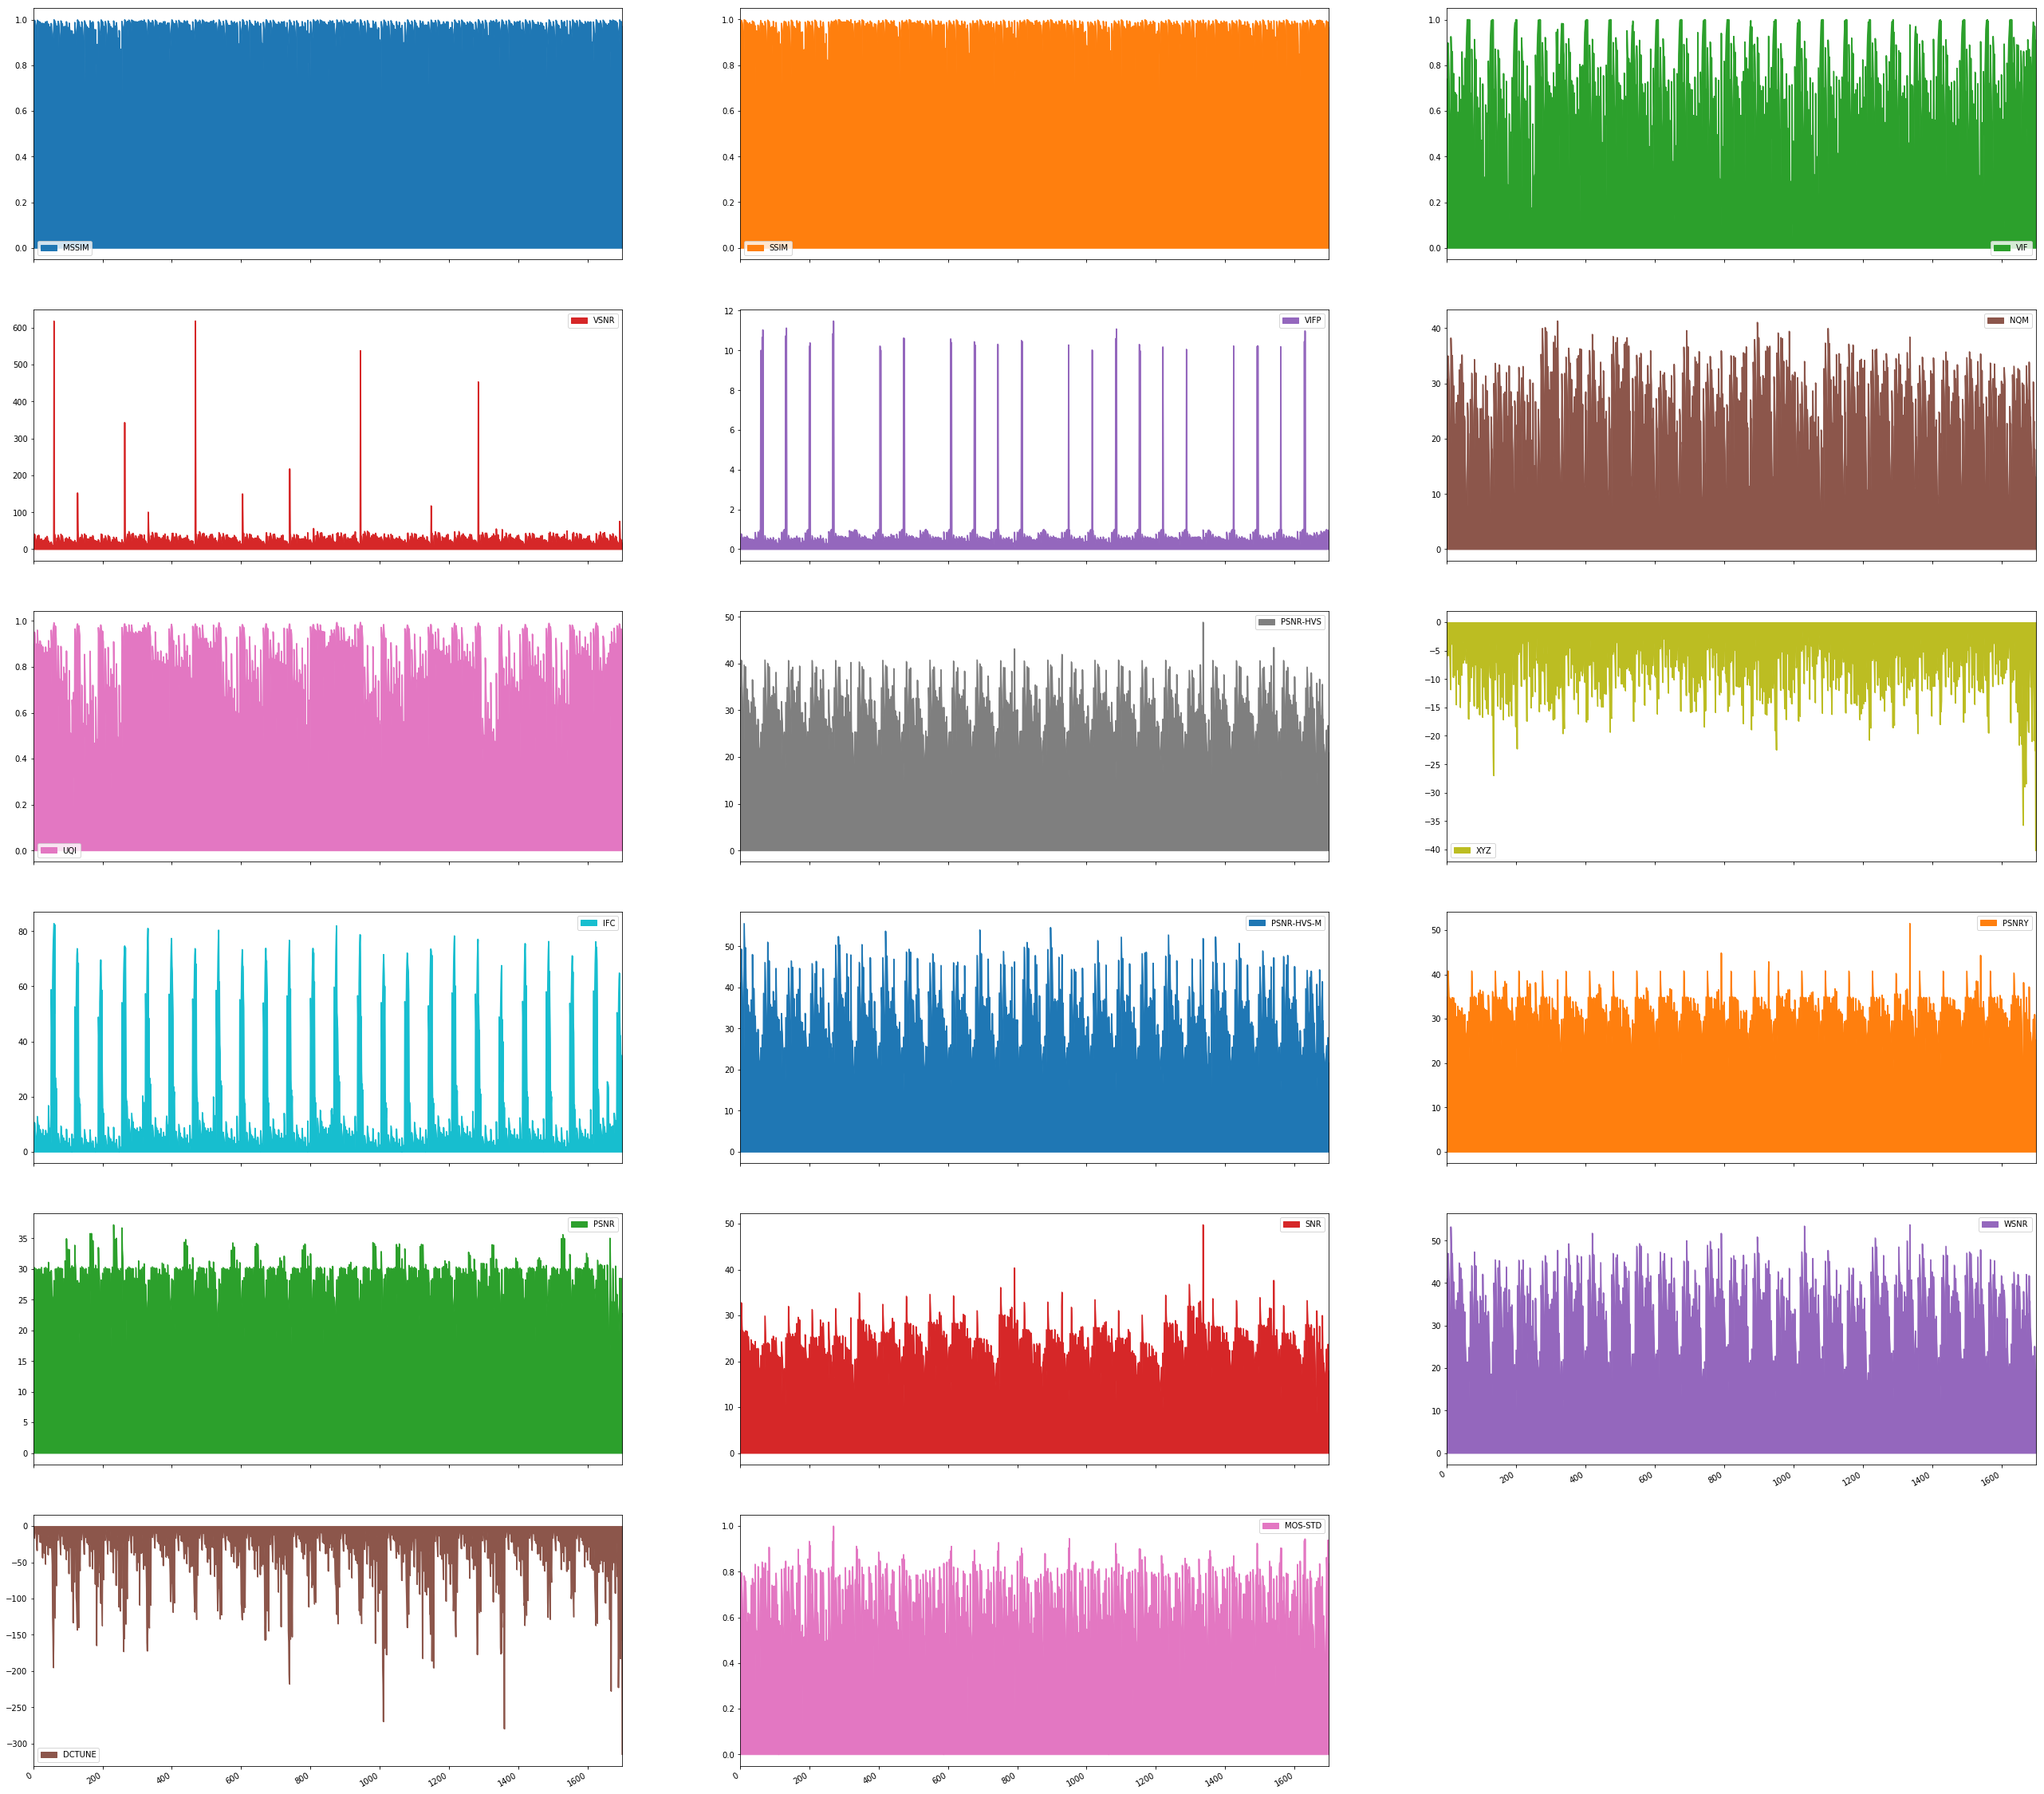

In [3]:
datasetFile = "dataset.csv"
dataFrame = pd.read_csv(datasetFile, sep = ';',header = 0)

# Remove the non-numeric columns
dataFrame = dataFrame._get_numeric_data()
dataFrame = dataFrame.dropna(axis='columns')

# Drop unneeded features
dataFrame = dataFrame.drop('MOS', 1)

# Get the numeric headers in a python list
numericHeaders = list(dataFrame.columns.values)

# Get a numpy array
npData = dataFrame.values

# Plot the raw data
plt.rcParams["figure.figsize"]=45,45
dataFrame.plot(kind='area', subplots=True, layout=(6,3))
plt.show()

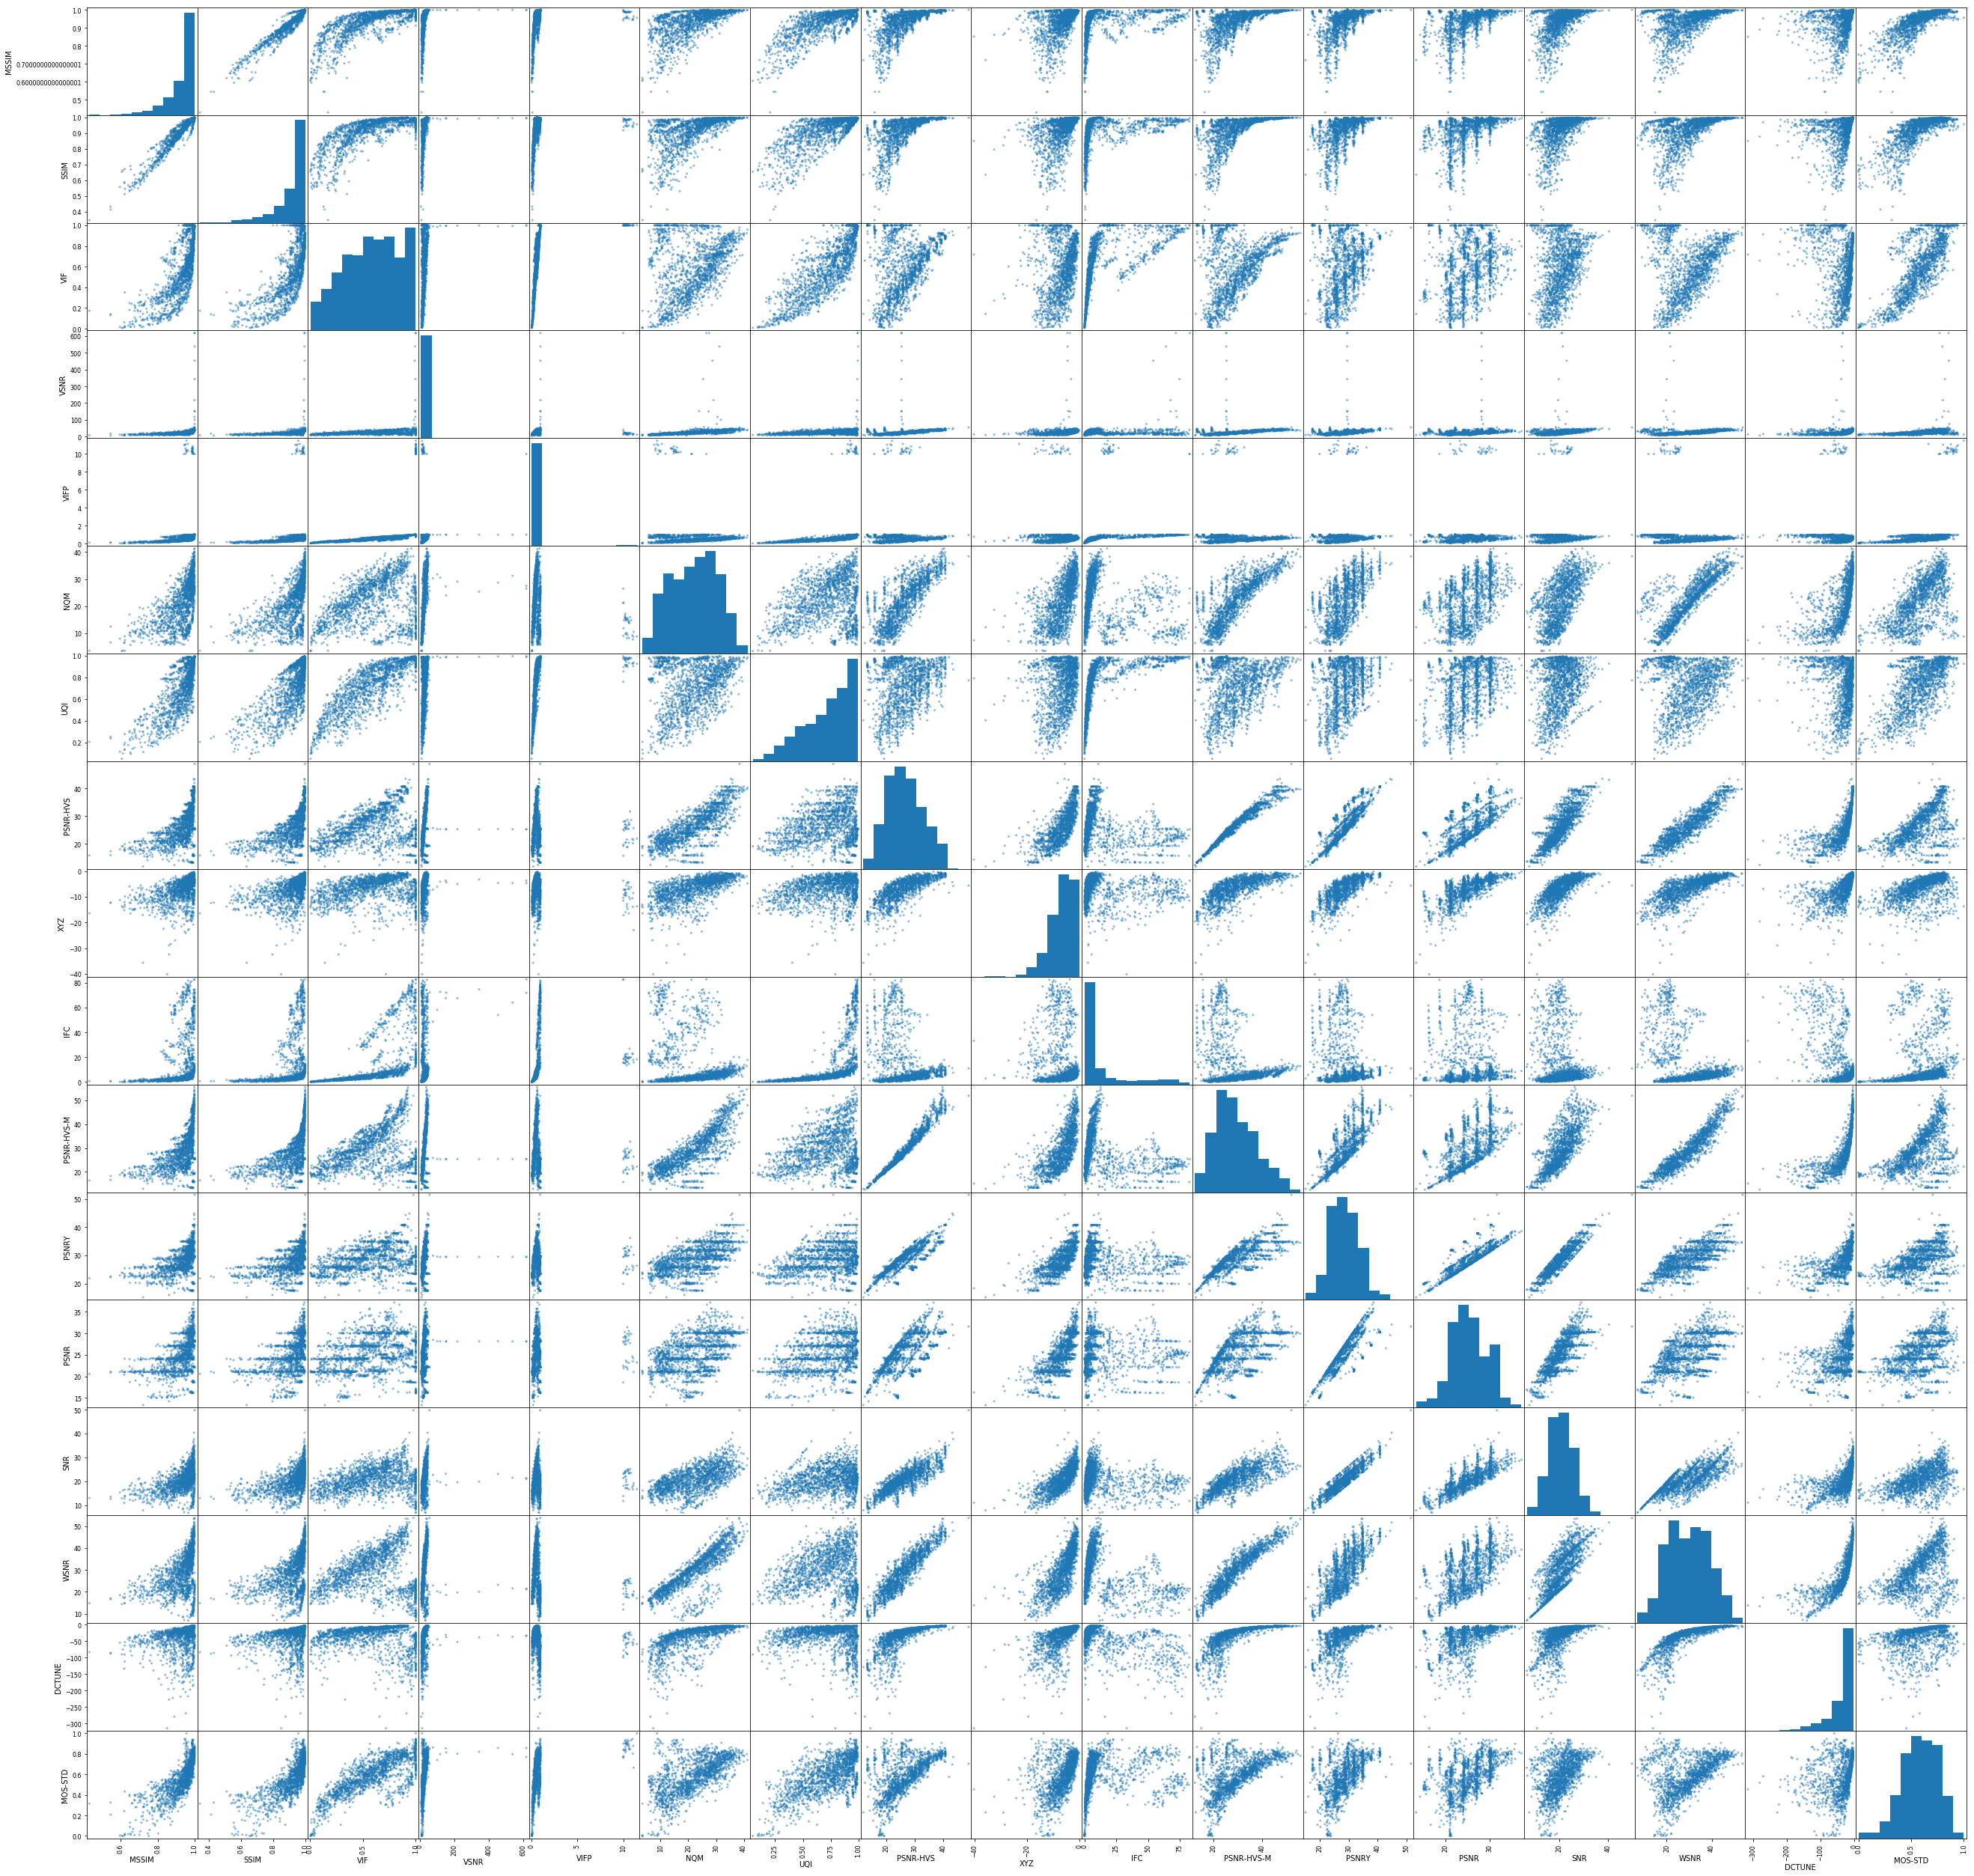

In [4]:
scatter_matrix(dataFrame)
plt.show()

De las gráficas anteriores se pude determinar la precesia de outliers en diferentes **features** del conjunto de datos. En la siguiente porción de código se eliminan los outliers, sustituyendo aquellos valores que se salen de un rango de desviación estandard (+-3) por un valor medio.

In [5]:
for metric in numericHeaders:
    mean, std = dataFrame[metric].mean(), dataFrame[metric].std()
    outliers = (dataFrame[metric] - mean).abs() > 3*std
    dataFrame[metric][outliers] = mean

El último paso, como parte del pre-procesamiento de los datos, corresponde a la normalización de estos para que estén en un rango de 0 a 1. Esto con el objetivo de ayudar a la red a converger más rápidamente.

In [6]:
from sklearn import preprocessing

# Normilize the following metrics
normMetrics = ['VSNR','VIFP','NQM','XYZ','PSNR-HVS','IFC','PSNR-HVS-M','PSNRY','WSNR','SNR','PSNR','DCTUNE']
normFrame = dataFrame[normMetrics]
dataFrame[normMetrics] = preprocessing.normalize(dataFrame[normMetrics], norm='l2')

## Dividir el conjunto de datos

En esta sección lo que se realiza es la partición de los datos en un cojunto para entrenamiento y otro conjunto para pruebas. La proporción de cada conjunto es de un 70% para el conjunto de entrenamiento y 30% para el cojunto de pruebas. Estos datos son desordenados primeramente y luego se realiza la partición. Para reproducibilidad se especifica una semilla en la variable **random_state**.

In [7]:
# Split the data
train = dataFrame.sample(frac = 0.7, random_state = 200)
test = dataFrame.drop(train.index)

# Set the feature and target datasets
X_train = train.loc[:,numericHeaders[0]:numericHeaders[len(numericHeaders) - 2]]
Y_train = train["MOS-STD"]
X_test = test.loc[:,numericHeaders[0]:numericHeaders[len(numericHeaders) - 2]]
Y_test = test["MOS-STD"]

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

1190 train samples
510 test samples


## Arquitectura de la red neuronal

Seguidamente se procede a realizar el proceso de diseño de la red neuronal. Como no hay una regla que nos indique cuantos perceptrones, capas, entre otros hiperparámentros debemos utilizar ante un determinado conjunto de datos; se decidión iniciar con el caso más simple de red multicapa de perceptrones. Esta red se utilizaría como base para que a partir de allo, ir optimizando el diseño.

Es importante mencionar que para nuestro caso vamos a utilzar una métrica de evaluación del desempeño de la red llamada Coeficiente de determinación o R2. Consiste en una medida estadística que indica la varianza de los datos, entre los predichos y los verdaderos.

In [21]:
model = Sequential()

model.add(Dense(128, input_dim=16))
model.add(Activation('relu'))
model.add(Dropout(.3))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


# Save model weights
Wsave = model.get_weights()

# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               2176      
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
__________

## Entrenamiento del modelo

Luego de haber definido la estructura del model, se continúa con el entrenamiento del mismo. Para ellos Keras cuenta con la función **fit**, donde especificamos el conjunto de entrenamiento (X_train, Y_train), la cantidad de epochs y el tamańo de los batches, entre otras variables. Para este caso seleccionamos una cantidad alta de epochs con el fin de estudiar el comportameinto de la red. Luego estos epcoch se pueden ajustar de acuerdo al rendimiento que haya demostrado la red.

In [22]:
# Training the model
history = model.fit(X_train, Y_train, epochs=2000, batch_size=100, validation_split=0.25, verbose=0)

## Verificación del modelo

Como último paso en esta primera iteración del proceso de diseño, corresponde evaluar el rendimiento de la red, luego de haber terminado su entrenamiento. Primero se obtiene la precisión en el conjunto de entrenamiento y en el conjunto de prueba, y luego se grafica los resultados.

In [23]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, Y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, Y_test)
print("\n Testing Accuracy:", score[1])

1190/1190 [==============================] - 0s 55us/step

 Training Accuracy: 0.912507276975808
510/510 [==============================] - 0s 49us/step

 Testing Accuracy: 0.82363074129703


El siguiente gráfico de dispersión corresponde a la precisión de la red en ambos conjuntos de datos. Para ambos gráficos, el eje Y corresponde a los datos predecidos por la red y el eje X corresponden a los datos esperados o reales. Si estos datos se encuentra muy dispersos es un indicativo de que el rendimiento de la red en dicho conjunto de datos no ha sido bueno; mientras que por el contrario, si los puntos estan muy conjuntados alrededor de la línea roja (que marca el caso ideal), indica un buen rendimiento de la red.

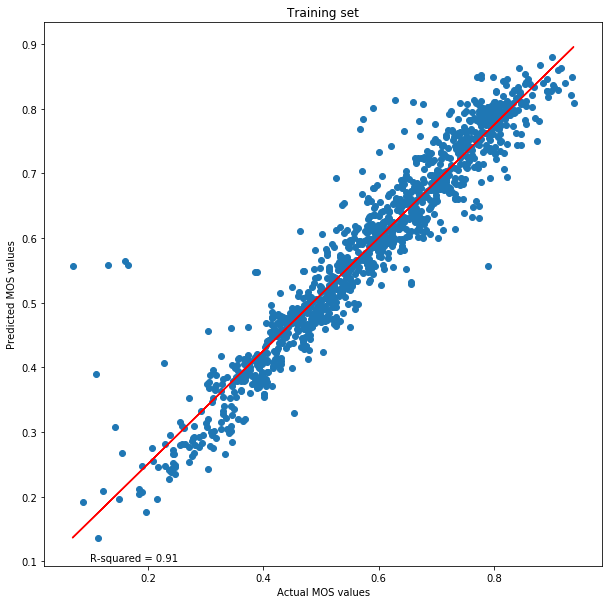

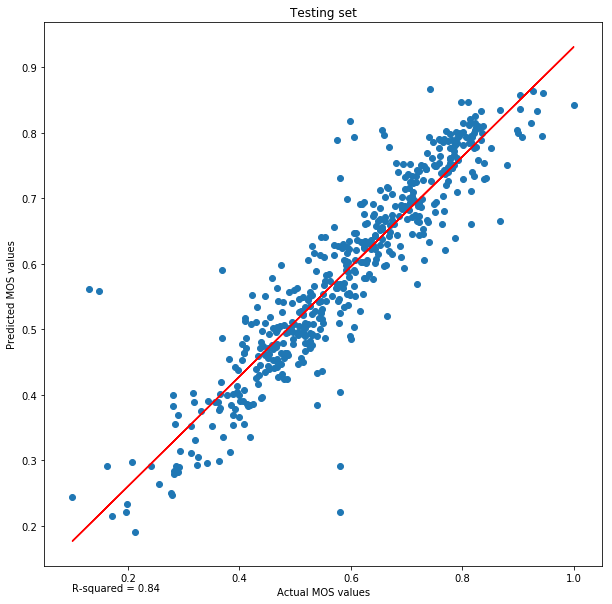

In [17]:
from sklearn.metrics import r2_score

def plot_metric(group, output, title):
    y_test = output.values
    Y_pred = model.predict(group)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')
    plt.text(0.1, 0.1, 'R-squared = %0.2f' % r_squared)
    plt.show()
 
plt.rcParams["figure.figsize"]=10,10
plot_metric(X_train, Y_train, 'Training set')
plot_metric(X_test, Y_test, 'Testing set')

El último conjunto de gráficos que, como parte del análisis de los resultados, vamos a utilizar son los de la precisión y la función de pérdida.

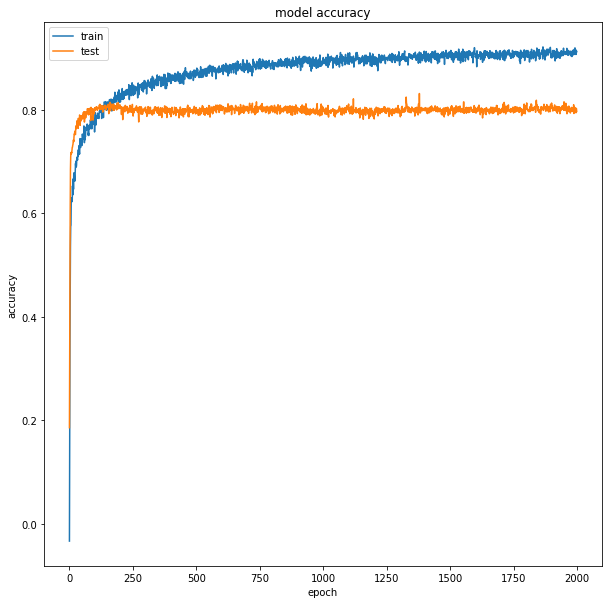

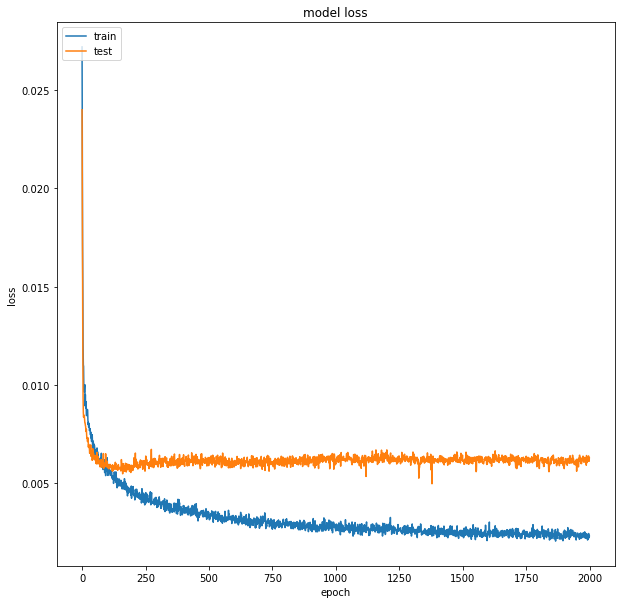

In [18]:
def print_result(model_history):
    # summarize history for accuracy
    plt.plot(model_history.history['coeff_determination'])
    plt.plot(model_history.history['val_coeff_determination'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
print_result(history)

De acuerdo a los resultados obtenidos en este primer entrenamiento de la red, esta precenta un sobreajuste (overfiting), ya que el renidmiento de la red en el conjunto de entrenamiento es bastante bueno, sin embargo este no es el caso para el conjunto de prueba. En la siguiente sección se explorará algunas de las técnicas que pueden reducir este sobreajuste.

## Reducción del sobre-ajuste

Exiten diferentes técnicas para mejorar la generalización de los datos, como es el caso del Dropout, la regularización (L1 y L2) y el ***Early Stopping***.

En nuestro caso el disño de la red ya cuenta con un porcentaje de Dropout en sus capas ocultas, por lo que intentaremos el ***Early Stopping***. Esta técnica consiste en el monitorieo del entrenamiento de la red, para que en el momento que se detecte una tendencia en detrimento de rendimiento de la misma, se pare el entrenamiento.

En la siguiente proción de código, primeramente se reestablcen los precos previos al entrenamiento anterior, ya que es con dicho entrenamiento, la red ya contaba con un sesgo que provocaba el sobre ajuste. Luego se agrega un ***callback*** correspondiente al EarlyStopping encargado el monitoreo del entrenamiento.

In [24]:
# Reset the model weights
model.set_weights(Wsave)

# Training the model
es = EarlyStopping(monitor='val_coeff_determination', mode='max', patience=50, verbose=1)
history = model.fit(X_train, Y_train, epochs=2000, batch_size=100, validation_split=0.25, callbacks=[es], verbose=0)

Epoch 00259: early stopping


Vemos que en este caso el entrenamiento fue suspendido en el epoch 259. Ahora procedamos a re-evaluar el modelo.

In [26]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, Y_train)
print("\n Training Accuracy:", score[1])
score = model.evaluate(X_test, Y_test)
print("\n Testing Accuracy:", score[1])

1190/1190 [==============================] - 0s 68us/step

 Training Accuracy: 0.853281492646001
510/510 [==============================] - 0s 74us/step

 Testing Accuracy: 0.8126511622877682


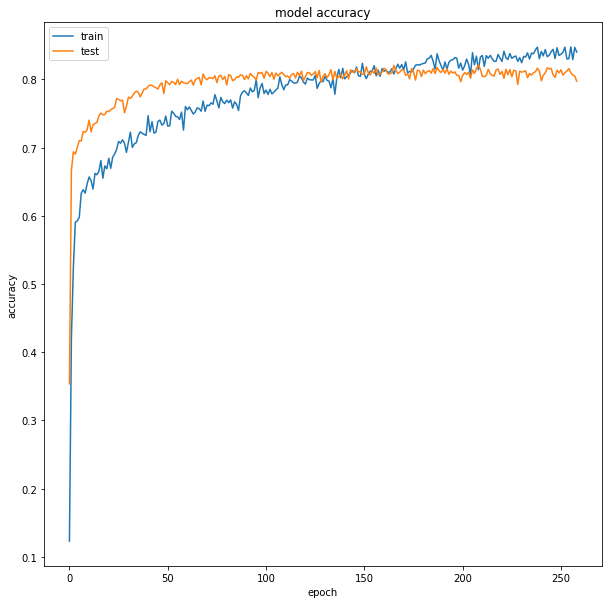

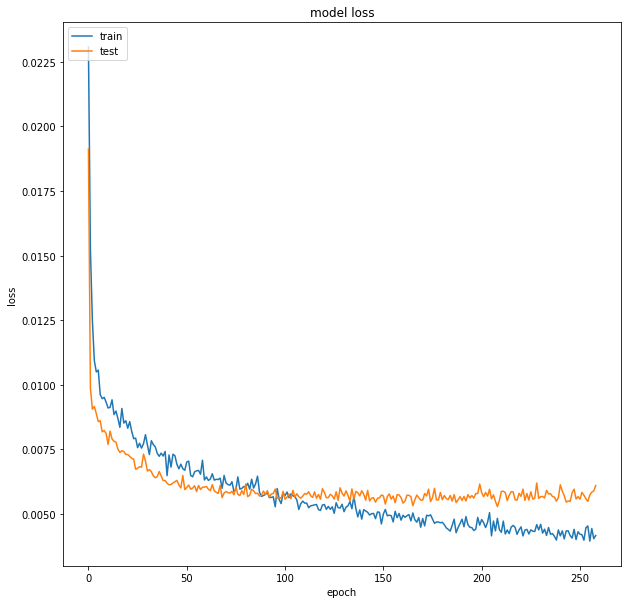

In [25]:
print_result(history)

De acuerdo a estos últimos resultados, vemos que la brecha en cuanto a rendimeinto y pérdida del modelo, entre los conjuntos de entrenamiento y prueba, se ha reducido. Basicamente el conjunto de entrenamiento se a equiparado el de prueba, disminuyendo su rendimiento.

## Exploración de los hiperparámetros

Ya contamos con nuestra red que posee un rendimiento aceptable y una buena generalización; sin embargo siempre a espacio a una mejora. Si bien es cierto la generalización de nuestro modelo es buena, el rendimiento lo podemos tratar de mejorar. Para ello debemos de realizar ajustes a los hiperparámetros de la red.

Existen diferentes técnicas que nos pueden ayudar en este propósito:
* Grid Search: Es un recorrido por todas las combinaciones de hiperparámetros que deseamos variar.
* Random search: Es una extensión del Grid Search, con la diferencia de que no se exploran todas las combinaciones, sino que se eligen de manera aleatoria.
* Bayesian optimization: función de optimización para encontrar los mejores hiperparámetros, de acuerdo a una determinada métrica.

En este caso estamos utilizando le biblioteca Talos que nos permiten aplicar la técnica de **Random Search**.

In [90]:
def pvqm_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()

    model.add(Dense(params['first_neuron'], input_dim=16))
    model.add(Activation('relu'))
    model.add(Dropout(params['dropout']))
    
    hiddenLayers = params['hidden_layers']
    for layer in range(hiddenLayers):
        model.add(Dense(params['second_neuron']))
        model.add(Activation('relu'))
        model.add(Dropout(params['dropout']))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Custom metric of Determination R2
    def coeff_determination(y_true, y_pred):
        SS_res =  K.sum(K.square( y_true-y_pred )) 
        SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )


    # Compiling the model
    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=[coeff_determination, 'acc'])
    
    # Training the model
    es = EarlyStopping(monitor='val_coeff_determination', mode='max', patience=50, verbose=1)
    history = model.fit(x_train, 
                        y_train, 
                        epochs=2000, 
                        batch_size=100, 
                        validation_split=0.25, 
                        callbacks=[es],
                        validation_data=[x_val, y_val],
                        verbose=0)
    
    return history, model

In [91]:
p = {'first_neuron':[32,64,128],
     'second_neuron':[16,32,64],
     'dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
     'hidden_layers':[1,2]}

x = dataFrame.loc[:,numericHeaders[0]:numericHeaders[len(numericHeaders) - 2]]
y = dataFrame["MOS-STD"]

# and run the experiment
t = ta.Scan(x=X_train.values,
            y=Y_train.values,
            x_val=X_test.values,
            y_val=Y_test.values,
            val_split=.25,
            model=pvqm_model,
            params=p,
            dataset_name='pqvm',
            experiment_no='1',
            grid_downsample=.2,
            random_method='quantum',
            reduction_metric='val_coeff_determination',
            disable_progress_bar=True)

Epoch 00230: early stopping
Epoch 00458: early stopping
Epoch 00375: early stopping
Epoch 00888: early stopping
Epoch 00678: early stopping
Epoch 00343: early stopping
Epoch 00278: early stopping
Epoch 00509: early stopping
Epoch 00469: early stopping
Epoch 00051: early stopping
Epoch 00290: early stopping
Epoch 00532: early stopping
Epoch 00432: early stopping
Epoch 00374: early stopping
Epoch 00765: early stopping
Epoch 00479: early stopping
Epoch 01173: early stopping
Epoch 00547: early stopping
Epoch 00430: early stopping
Epoch 00628: early stopping
Epoch 00304: early stopping
Epoch 01028: early stopping
Epoch 00386: early stopping
Epoch 00384: early stopping
Epoch 00363: early stopping
Epoch 00440: early stopping
Epoch 00381: early stopping
Epoch 00240: early stopping
Epoch 00610: early stopping
Epoch 00830: early stopping
Epoch 00661: early stopping
Epoch 00504: early stopping
Epoch 00248: early stopping
Epoch 00531: early stopping
Epoch 00519: early stopping
Epoch 00083: early s

In [92]:
r = ta.Reporting(t)
r.data.head(-3)

round_epochs  val_loss  val_coeff_determination   val_acc      loss  \
0            230  0.005155                 0.091284  0.001961  0.006204   
1            458  0.004217                 0.263788  0.001961  0.004693   
2            375  0.009694                -0.325701  0.001961  0.013659   
3            888  0.003598                 0.177619  0.001961  0.003275   
4            678  0.004009                 0.208548  0.001961  0.003692   
5            343  0.005601                 0.095457  0.001961  0.009874   
6            278  0.006647                -0.105182  0.001961  0.009723   
7            509  0.005006                -1.227759  0.001961  0.005735   
8            469  0.005359                 0.097874  0.001961  0.008468   
9             51  0.019794                -0.154292  0.001961  0.024473   
10           290  0.009675                -0.263478  0.001961  0.015633   
11           532  0.004937                 0.121095  0.001961  0.006024   
12           432  0.003872                -0.092875  0.001961  0.004216   
13           374  0.004371                 0.205604  0.001961  0.003523   
14           765  0.004666                -0.056747  0.001961  0.007449   
15           479  0.006041                 0.072130  0.001961  0.007920   
16          1173  0.003640                -0.027681  0.001961  0.002514   
17           547  0.009542                -0.198538  0.001961  0.016229   
18           430  0.007108                 0.106273  0.001961  0.010652   
19           628  0.003892                -0.171782  0.001961  0.004832   
20           304  0.012582                -0.330990  0.001961  0.017583   
21          1028  0.003559                -0.227657  0.001961  0.003764   
22           386  0.011224                -0.396309  0.001961  0.018761   
23           384  0.018976                -0.372786  0.001961  0.020137   
24           363  0.008261                -0.027425  0.001961  0.013286   
25           440  0.005883                 0.011847  0.001961  0.009081   
26           381  0.006924                -0.144266  0.001961  0.009286   
27           240  0.005908                 0.110452  0.001961  0.006213   
28           610  0.019165                -0.579899  0.001961  0.021041   
29           830  0.003187                 0.288154  0.001961  0.002638   
30           661  0.003243                 0.188078  0.001961  0.003120   
31           504  0.003762                 0.117142  0.001961  0.003376   
32           248  0.016494                -0.215646  0.001961  0.019627   

    coeff_determination  acc  first_neuron  second_neuron  dropout  \
0             -0.160870  0.0            64             64      0.5   
1             -0.046085  0.0           128             64      0.5   
2             -1.783391  0.0            32             64      0.8   
3              0.056955  0.0            32             32      0.1   
4              0.036992  0.0            32             32      0.1   
5             -0.707339  0.0           128             16      0.7   
6             -0.285278  0.0            32             32      0.6   
7             -2.764540  0.0            32             64      0.4   
8             -1.116067  0.0           128             64      0.8   
9             -1.673157  0.0            64             16      0.9   
10            -1.305849  0.0            64             16      0.8   
11            -0.383425  0.0            32             32      0.4   
12            -0.288988  0.0           128             16      0.2   
13             0.090881  0.0            32             64      0.1   
14            -0.572078  0.0           128             32      0.7   
15            -0.253927  0.0            32             32      0.5   
16            -0.274650  0.0            32             64      0.0   
17            -2.002217  0.0           128             32      0.8   
18            -1.908141  0.0            64             64      0.8   
19            -0.444157  0.0            64           

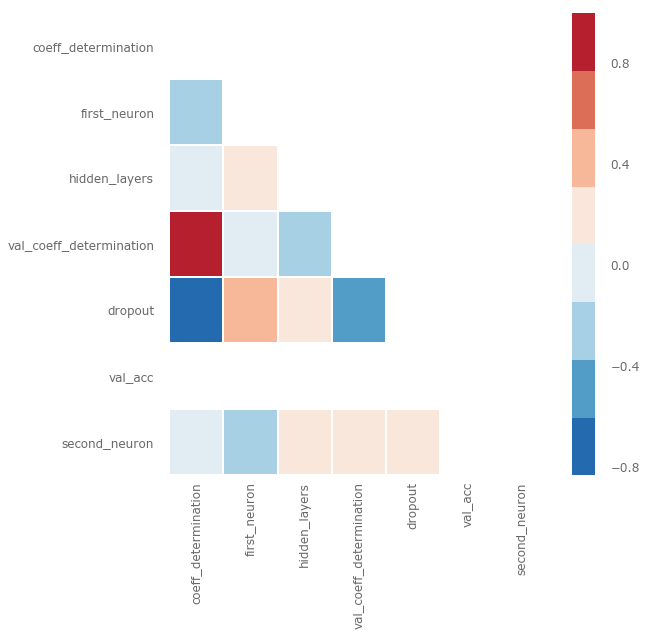

In [94]:
r.plot_corr()

De todas las combinaciones probadas por el Random Search, curiosamente ninguna supera en rendimiento a la de la arquitectura origina. Sin embargo, esto no quiere decir que dicha arquitectura es la mejor, sino que quiza la exploración de los hiperparámetros no fue lo suficientemente rigurosa.